# ⭐Imports


In [1]:
from FUNCTIONS import *
%matplotlib inline

TensorFlow Version:  2.1.0


---

# ⭐ Building Classifier

## 🔵 Step 1: Preprocess Data (Create Dataset)

1. Preprocess Signal & Background Data
2. Concatenate & Shuffle signal/background data
3. Convert to tf.data.Dataset object



## 🔵 Step 2: Create Batches

Batches: number of events with which you update trained parameters once

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Theory guide: https://www.tensorflow.org/guide/data_performance#prefetching

## 🔵 ML Notes
### 🔴 Compile the Model


- **Optimizer** -- Determines how the model is updated based on the data it sees and its loss function
- **Loss Function** -- Measures how accurate the model is during training
- **Metrics** -- Monitors the training and testing steps. 

### 🔴 Fit the Model

## Notes

**Early Stopping**: <br /> 
Stop training when there is no improvement in the validation loss for 5 consecutive epochs or when metric gain is less than 0.001

**Save Best**: <br />
Saves the best model

## Notes
#### Activation Function (non normalised)
- **Relu**: sometimes results in all predictions being 0 
- **tanh**: solves this issue; accuracy (n = 1): 73
- **softsign**: solves and performs similarly to tanh
- **elu**: solves and performs slightly better than tanh

#### Activation Function (log)
- **softsign**: only softsign works. accuracy: 67

#### Activation Function (normal)
- Nothing has worked

### Other hyperparameters
- kernel_size = 2, 3, 5, 7 perform best (very similarly to one another)
- padding = 'valid', 'same' result in very similar performance
- filters: tried small (8 in all) to large (256 in all) and they perform similarly to one another. 

Create Dataset

In [3]:
# # # Create Datasets
# start = time.time()
# data_s = create_dataset('data/dataset_s_180k.dat')
# data_b = create_dataset('data/dataset_b_180k.dat')
# end = time.time()
# print('Time taken for signal: {:.3f} minutes'.format((end-start)/60))

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_180k')
# pd.DataFrame(data_b).to_csv('data_b_180k')

Time taken for signal: 83.347 minutes


Load 

In [9]:
# MAIN
data_s = np.array(pd.read_csv('data/data_s_500k').iloc[:, 1:])
data_b = np.array(pd.read_csv('data/data_b_500k').iloc[:, 1:])

# Slice & Save
events_no = int(100000)
data_s = data_s[0:events_no*40, 0:40]
data_b = data_b[0:events_no*40, 0:40]

In [9]:
# # Create Datasets
# start = time.time()
# data_s = create_dataset('data/dataset_s_500k.dat')
# data_b = create_dataset('data/dataset_b_500k.dat')
# end = time.time()
# print('Time taken: {:.3f} minutes'.format((end-start)/60))

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_500k')
# pd.DataFrame(data_b).to_csv('data_b_500k')

Time taken: 232.061 minutes


ML Preprocess

Total Events: 200000
Total Labels: 200000
Shape:  (200000, 40, 40, 1)
 
Train:  (139400, 40, 40, 1) (139400,)
Val:  (30600, 40, 40, 1) (30600,)
Test:  (30000, 40, 40, 1) (30000,)
 
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((40, 40, 1), ()), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((64, 40, 40, 1), (64,)), types: (tf.int64, tf.int64)>

train, val, test:  2178 478 468


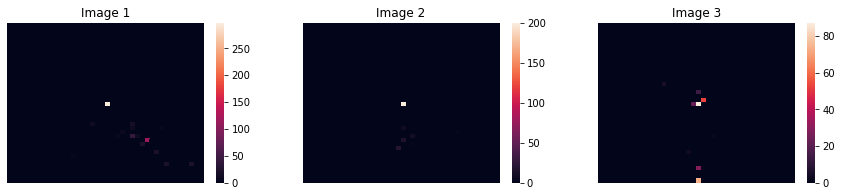

In [10]:
batch_size=64
train_batches, val_batches, test_batches, num_of_batches_train, num_of_batches_val, num_of_batches_test = preprocess_ML_tf(data_s, data_b, batch_size=batch_size)

#### 🔴 Confusion Matrix & ROC Curve (unseen test data)

Note ROC: For relu activation function (i.e. model outputs two probabilities per event, [P(background), P(signal)]

In [8]:
model1

In [15]:
model0 = tf.keras.models.load_model('models/model_relu_7579_1mil.h5')
model1 = tf.keras.models.load_model('models/model_7774.h5')
model2 = tf.keras.models.load_model('models/model_7971.h5')

models = [model0, model1, model2]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\johng\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-189cc6854889>", line 1, in <module>
    model0 = tf.keras.models.load_model('models/model_relu_7579_1mil.h5')
  File "C:\Users\johng\anaconda3\lib\site-packages\tensorflow_core\python\keras\saving\save.py", line 146, in load_model
    return hdf5_format.load_model_from_hdf5(filepath, custom_objects, compile)
  File "C:\Users\johng\anaconda3\lib\site-packages\tensorflow_core\python\keras\saving\hdf5_format.py", line 168, in load_model_from_hdf5
    custom_objects=custom_objects)
  File "C:\Users\johng\anaconda3\lib\site-packages\tensorflow_core\python\keras\saving\model_config.py", line 55, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "C:\Users\johng\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\serializa

TypeError: ('Keyword argument not understood:', 'groups')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 38, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

[[0.77006767 0.22993233]
 [0.25870413 0.74129587]]


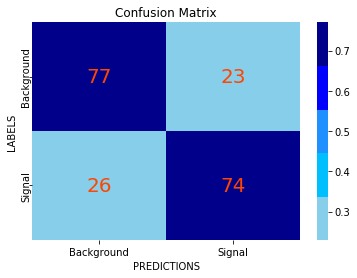

[[0.79353811 0.20646189]
 [0.29242557 0.70757443]]


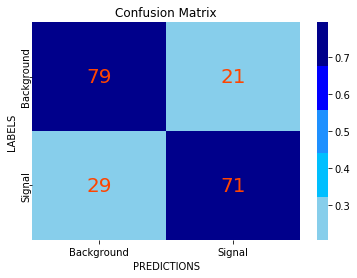

In [12]:
cmx_tf(models, test_batches, num_of_batches_test)

In [ ]:
cmx_tf(models, test_batches, num_of_batches_test)

In [ ]:
ROC3_tf(model0, model1, model2, test_batches, num_of_batches_test)

---

---

---

---

---

---

---

---

# 🔵 Build the Model

### 🔴 Learning Curve (underfitting test)
Determine whether a larger dataset could improve performance



 0.1 

Accuracy on the Test Set: 74.0%


 0.2 

Accuracy on the Test Set: 74.2%


 0.4 

Accuracy on the Test Set: 74.5%


 0.6 

Accuracy on the Test Set: 75.5%


 0.8 

Accuracy on the Test Set: 73.6%


 1 

Accuracy on the Test Set: 75.6%


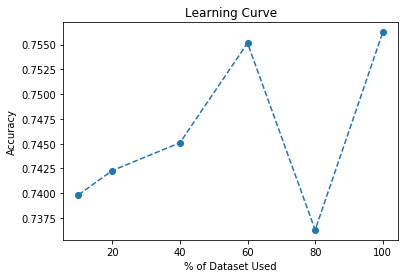

In [5]:
learning_curve(train_batches, val_batches, test_batches, num_of_batches_train, num_of_batches_val)

### 🔴 Train Model (with Hyperparameter Tuning)

In [23]:
input_shape=(40, 40, 1)
kernel_size = 2
padding='valid'
activation = 'relu'

activations = ['elu', 'exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
kernels = [1, 3, 5, 7, 9, 11]
paddings = ['valid', 'same']
paddings = ['valid']
filters = [8, 16, 64, 256, 512]

for padding in paddings:

    model = tf.keras.Sequential([
              tf.keras.Input(shape=input_shape),
              tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.4),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.4),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.4),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation=activation),
              tf.keras.layers.Dropout(0.4),
              tf.keras.layers.Dense(2, activation = 'softmax')
    ])


    # Compile Model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=111, min_delta = 0.001)
    save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

    print('\n\n', activation, '\n')

    # Fit model to training data
    EPOCHS = 25

    history = model.fit(train_batches, 
              epochs=EPOCHS,
              callbacks= [early_stopping, save_best],
              validation_data=val_batches, 
              verbose=1
              )
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)

    print('\nLoss on the Test Set: {:,.3f}'.format(loss))
    print('Accuracy on the Test Set: {:.1%}'.format(accuracy))



 relu 

Train for 108 steps, validate for 23 steps
Epoch 1/25
108/108 [==============================] - 4s 41ms/step - loss: 0.6559 - accuracy: 0.6529 - val_loss: 0.6297 - val_accuracy: 0.6787
Epoch 2/25
108/108 [==============================] - 4s 37ms/step - loss: 0.6341 - accuracy: 0.6772 - val_loss: 0.6190 - val_accuracy: 0.6916
Epoch 3/25
108/108 [==============================] - 4s 37ms/step - loss: 0.6230 - accuracy: 0.6892 - val_loss: 0.6283 - val_accuracy: 0.6807
Epoch 4/25
108/108 [==============================] - 4s 37ms/step - loss: 0.6255 - accuracy: 0.6856 - val_loss: 0.6174 - val_accuracy: 0.6936
Epoch 5/25
108/108 [==============================] - 4s 37ms/step - loss: 0.6281 - accuracy: 0.6836 - val_loss: 0.6156 - val_accuracy: 0.6957
Epoch 6/25
108/108 [==============================] - 4s 38ms/step - loss: 0.6144 - accuracy: 0.6982 - val_loss: 0.6238 - val_accuracy: 0.6868
Epoch 7/25
108/108 [==============================] - 4s 37ms/step - loss: 0.6319 - accur

In [16]:
input_shape=(40, 40, 1)
kernel_size = 2
padding='valid'
activation = 'relu'

activations = ['elu', 'exponential', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
kernels = [1, 3, 5, 7, 9, 11]
paddings = ['valid', 'same']
paddings = ['valid']
filters = [8, 16, 64, 256, 512]

for padding in paddings:

    model = tf.keras.Sequential([
              tf.keras.Input(shape=input_shape),
              tf.keras.layers.Conv2D(16, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(32, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding=padding, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.MaxPooling2D(),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(128, activation=activation),
              tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(2, activation = 'softmax')
    ])


    # Compile Model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)
    save_best = tf.keras.callbacks.ModelCheckpoint('./model_recent.h5', monitor='loss', save_best_only=True)

    print('\n\n', activation, '\n')

    # Fit model to training data
    EPOCHS = 5

    history = model.fit(train_batches, 
              epochs=EPOCHS,
              callbacks= [early_stopping, save_best],
              validation_data=val_batches, 
              verbose=1
              )
    
    loss, accuracy = model.evaluate(test_batches, verbose=0)

    print('\nLoss on the Test Set: {:,.3f}'.format(loss))
    print('Accuracy on the Test Set: {:.1%}'.format(accuracy))



 relu 

Train for 108 steps, validate for 23 steps
Epoch 1/5
108/108 [==============================] - 4s 41ms/step - loss: 0.6526 - accuracy: 0.6534 - val_loss: 0.6273 - val_accuracy: 0.6841
Epoch 2/5
108/108 [==============================] - 4s 37ms/step - loss: 0.6197 - accuracy: 0.6904 - val_loss: 0.6249 - val_accuracy: 0.6855
Epoch 3/5
108/108 [==============================] - 4s 37ms/step - loss: 0.6195 - accuracy: 0.6923 - val_loss: 0.6101 - val_accuracy: 0.6997
Epoch 4/5
108/108 [==============================] - 4s 37ms/step - loss: 0.6140 - accuracy: 0.6975 - val_loss: 0.6083 - val_accuracy: 0.7018
Epoch 5/5
108/108 [==============================] - 4s 37ms/step - loss: 0.6114 - accuracy: 0.7001 - val_loss: 0.6113 - val_accuracy: 0.6990

Loss on the Test Set: 0.618
Accuracy on the Test Set: 69.2%


#### 🔴 Model-Complexity Graph 

How performance changes with epochs

In [ ]:
model_complexity_graph(history)

#### 🔴 Evaluate Model

In [ ]:
model = tf.keras.models.load_model('model_relu_7570.h5')
#model.summary()

loss, accuracy = model.evaluate(test_batches, verbose=0)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.1%}'.format(accuracy))

#### 🔴 Visualise Predictions

In [ ]:
visualise_preds(model, test_batches)